In [1]:
# IMPORTS
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
colors = sns.color_palette('colorblind')

# UNDERSTAND EXP3 ALGORITHM

## Pseudo-Regret

The **pseudo-regret** $\bar{R_n}$ after $n$ rounds measures the difference between the expected cumulative loss of the algorithm and that of the best fixed arm in hindsight:

$$
\bar{R_n} = \mathbb{E} \left[ \sum_{t=1}^n \ell_{I_t, t} \right] - \min_{i \in \{1, ..., K\}} \mathbb{E} \left[ \sum_{t=1}^n \ell_{i,t} \right]
$$

A small pseudo-regret means the algorithm performs nearly as well as the best fixed arm in retrospect.

## Exp3 Algorithm (Exponential weights for Exploration and Exploitation)

**Parameter:** a non-increasing sequence of real numbers $(\eta_t)_{t \in \mathbb{N}}$.  
Let $p_1$ be the uniform distribution over $\{1, ..., K\}$.

For each round $t = 1, 2, ..., n$:
1. Draw an arm $I_t$ according to the probability distribution $p_t$.
2. For each arm $i = 1, ..., K$, compute the estimated loss:
   $$
   \hat{\ell}_{i,t} =
   \begin{cases}
   \dfrac{\ell_{i,t}}{p_{i,t}} & \text{if } I_t = i \\
   0 & \text{otherwise}
   \end{cases}
   $$
   and update the estimated cumulative loss:
   $$
   L_{i,t} = L_{i,t-1} + \hat{\ell}_{i,t}
   $$
3. Update the probability distribution over the arms:
   $$
   p_{i,t+1} = \frac{\exp(-\eta_t L_{i,t})}{\sum_{k=1}^{K} \exp(-\eta_t L_{k,t})}
   $$


/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_36473/3010043784.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


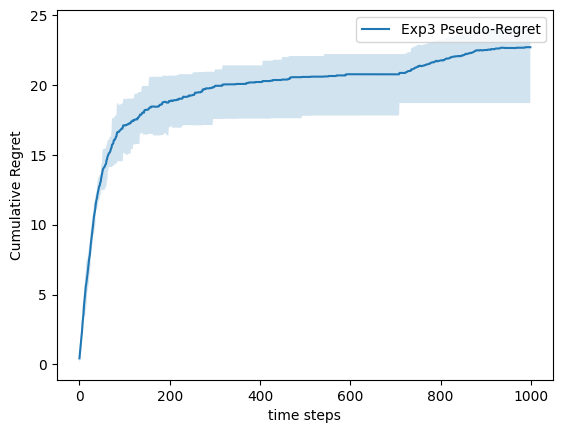

In [2]:
class Exp3:
    def __init__(self):
        self.K = 10              #NUMBER OF ARMS
        self.EPS = 1e-8          #DO NOT DIVIDE BY 0
        self.T = 1_000           #HORIZON
        self.nb_episodes = 10    #NB_EPISODES
        self.reset()     

    def reset(self):
        self.total_reward = 0
        self.p = np.full(self.K, 1.0 / self.K)   #UNIFORM DISTRIUBUTION
        self.L = np.zeros(self.K)
        self.environment_observe_losses = np.zeros(self.K)  #TO COMPUTE PSEUDO-REGRET
        self.incurred_loss = 0

    def compute_loss(self, k):
        """ Simulating the environment """
        for i in range(self.K):
            mean = i / self.K
            loss_i = np.random.normal(mean, 0.1)
            self.environment_observe_losses[i] += loss_i
            if k==i:
                loss = loss_i
                self.incurred_loss += loss_i
        return loss

    def perform_experiment(self):
        regrets = np.zeros((self.nb_episodes, self.T))
        for ep in range(self.nb_episodes):
            self.reset()
            for t in range(self.T):
                eta_t = np.sqrt(2*np.log(self.K)/self.T*self.K)  #DEFINE ETA
                I_t = np.random.choice(range(self.K), p=self.p)  #DRAW I_t
                l_t = self.compute_loss(I_t)                     #OBSERVE LOSS l_t
                l_hat = l_t / (self.p[I_t] + self.EPS)           #COMPUTE THE UNBIASED ESTIMATOR
                self.L[I_t] += l_hat                             #UPDATE THE LOSS VECTOR

                #UPDATE THE WEIGHTS
                weights = np.exp(-eta_t * self.L)
                self.p = weights / np.sum(weights)

                #THEN COMPUTE THE PSEUDO-REGRET
                best_arm = np.argmin(
                                self.environment_observe_losses) #ARM WITH LOWEST CUMULATIVE LOSS
                PSEUDO_REGRET_t = self.incurred_loss - self.environment_observe_losses[best_arm]
                regrets[ep, t] = PSEUDO_REGRET_t

        #PLOTTING THE CUMULATIVE PSEUDO-REGRET 
        reg_plot = plt.figure()
        mean_reg = np.mean(regrets, axis=0)
        q=10
        q_reg = np.percentile(regrets, q, axis=0)
        Q_reg = np.percentile(regrets, 100-q, axis=0)
        plt.plot(np.arange(self.T), mean_reg, label="Exp3 Pseudo-Regret")
        #plt.plot(np.arange(self.T), [2*np.sqrt(self.T*np.log(self.K))]*self.T, label="PSEUDO-REGRET Bound")
        plt.fill_between(np.arange(self.T), q_reg, Q_reg, alpha=0.2)
        plt.xlabel('time steps')
        plt.ylabel('Cumulative Regret')
        plt.legend()
        reg_plot.show()

exp3 = Exp3()
exp3.perform_experiment()

## Combined Exp3

### Notations

- $\mathcal{T} \equiv$ Tree with $L$ layers  
- $\mathcal{N} \equiv$ set of nodes  
- $\forall n \in \mathcal{N}, \mathcal{P} \equiv$ parent of $n$  
- $\forall n \in \mathcal{N}, \mathcal{C} \equiv$ set of children of $n$  
- $\mathcal{L} \equiv$ set of leaves  

### Algorithm

**Input:** Tree $\mathcal{T}$ with set $\mathcal{N}$ of nodes.  

**Initialize:**  
$\forall n \in \mathcal{N}, \quad P_{1}(n) = \frac{1}{| \mathcal{C}(\mathcal{P}(n))|}$  

**For** $t = 1, \dots, T$:  
- Set $l_t = \mathbf{0}_L$  
- Set $j = 0$  
- Set $n_t(j) \equiv \text{root}$  
- **While** $n_t(j) \notin \mathcal{L}$:
  - $j \leftarrow j + 1$
  - Sample $n_t(j) \sim p_t(n)\,\mathbf{1}\{m \in \mathcal{C}(n_t(j-1))\}$
  - Observe $\epsilon_t(n_t(j))$ and compute  
    $l_t(n_t(j)) = l_t(n_t(j-1)) + \epsilon_t(n_t(j))$
- Play leaf $i_t = n_t(j)$  
- **While** $j \ne 0$:
  - $j \leftarrow j - 1$
  - Update:

    $
    \forall n \in \mathcal{N}, \quad
    P_{t+1}(n) =
    \begin{cases}
    \dfrac{P_t(n) \exp\left( -\eta \tilde{l_t}(n) \right)}{\sum\limits_{m \in \mathcal{C}(n_t(j))} P_t(m) \exp\left( -\eta \tilde{l_t}(m) \right)} & \text{if } n \in \mathcal{C}(n_t(j)) \\
    P_t(n) & \text{otherwise}
    \end{cases}
    $

    $
    \forall n \in \mathcal{N}, \quad
    \tilde{l_t}(n) =
    \begin{cases}
    \dfrac{l_t(i_t) - l_t(n_t(j))}{P_t(n)} & \text{if } n = n_t(j-1) \\
    0 & \text{otherwise}
    \end{cases}
    $


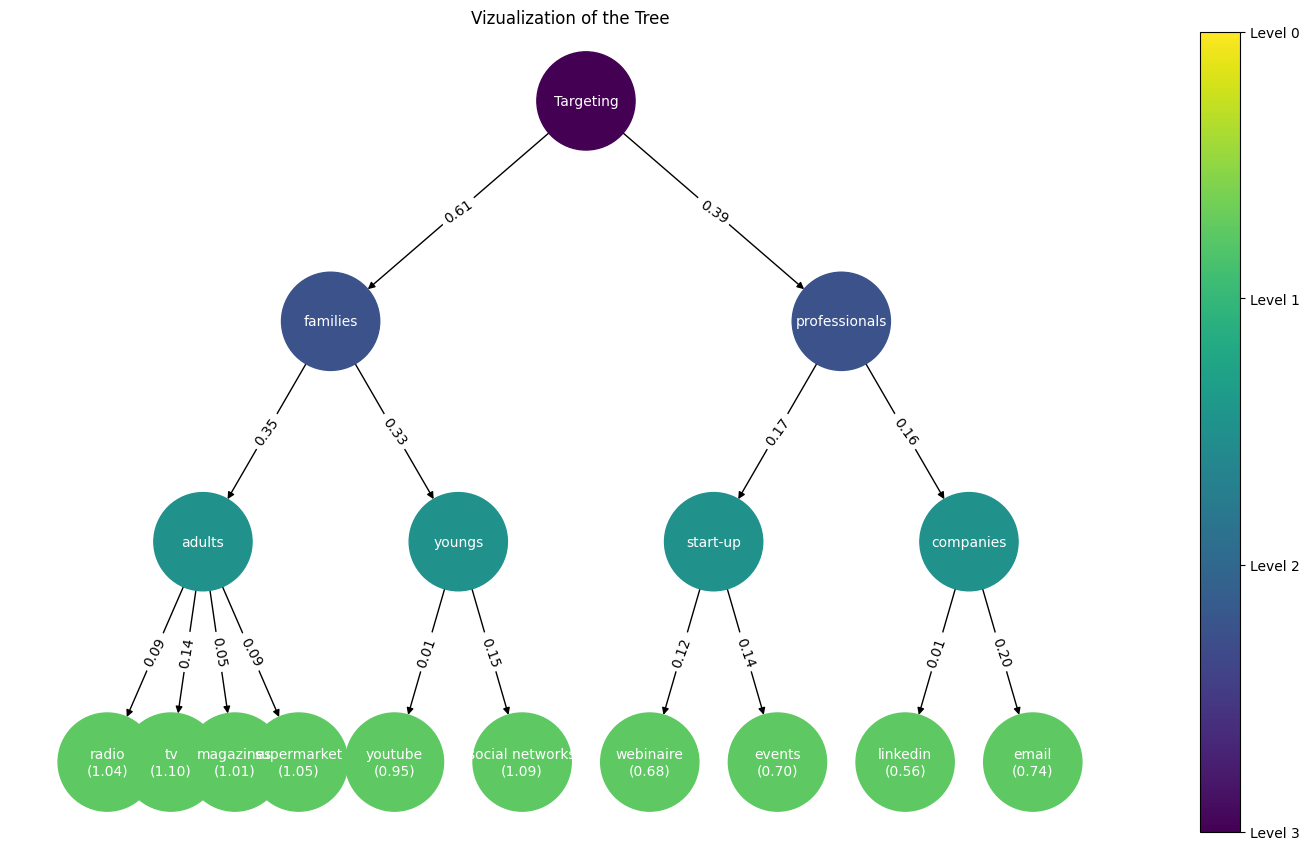

In [7]:
from src.environment.tree import Tree

tree = Tree() 
root = tree.insert(parent_node=None, name="Targeting", mean=0, var=0)

# First Layer
families, _ = tree.insert(parent_node=root, name="families", mean=4, var=0.1)
professionals, _ = tree.insert(parent_node=root, name="professionals", mean=2.5, var=0.1)

# Second Layer
adults, _ = tree.insert(parent_node=families, name="adults", mean=0.9, var=0.1)
youngs, _ = tree.insert(parent_node=families, name="youngs", mean=0.8, var=0.1)

start_up, _ = tree.insert(parent_node=professionals, name="start-up", mean=0.7, var=0.1)
companies, _ = tree.insert(parent_node=professionals, name="companies", mean=0.3, var=0.1)

# Third Layer
radio, _ = tree.insert(parent_node=adults, name="radio", mean=0.3, var=0.1)
tv, _ = tree.insert(parent_node=adults, name="tv", mean=0.2, var=0.1)
magazines, _ = tree.insert(parent_node=adults, name="magazines", mean=0.1, var=0.1)
tv, _ = tree.insert(parent_node=adults, name="supermarket", mean=0.3, var=0.1)

youtube, _ = tree.insert(parent_node=youngs, name="youtube", mean=0.1, var=0.1)
social_networks, _ = tree.insert(parent_node=youngs, name="social networks", mean=0.2, var=0.1)

webinaire, _ = tree.insert(parent_node=start_up, name="webinaire", mean=0.3, var=0.1)
events, _ = tree.insert(parent_node=start_up, name="events", mean=0.5, var=0.1)

linkedin, _ = tree.insert(parent_node=companies, name="linkedin", mean=0.02, var=0.1)
email, _ = tree.insert(parent_node=companies, name="email", mean=0.5, var=0.1)

tree.step()
tree.visualize_tree()

/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_34514/1082042064.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


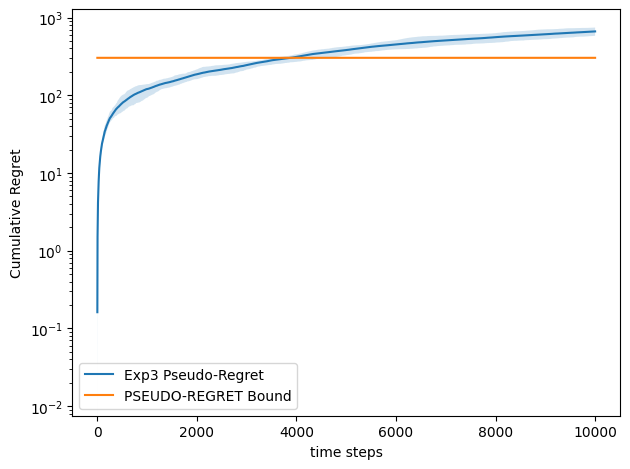

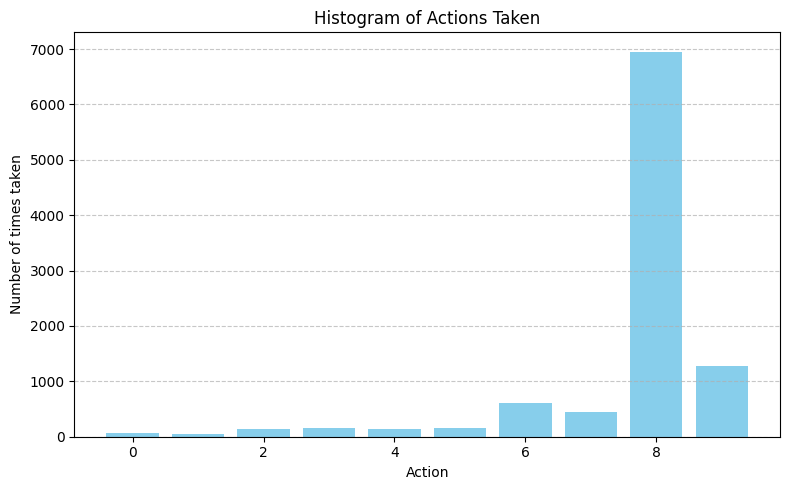

In [43]:
class Exp3:
    "Designed for Trees"
    def __init__(self, tree):
        self.tree = tree
        self.K = len(self.tree.get_reward_leaves())
        self.EPS = 1e-8          #DO NOT DIVIDE BY 0
        self.T = 10_000           #HORIZON
        self.nb_episodes = 10     #NB_EPISODES
        self.reset()     

    def reset(self):
        self.tree.step()
        self.best_arm=None
        self.total_reward = 0
        self.p = np.full(self.K, 1.0 / self.K)   #UNIFORM DISTRIUBUTION
        self.L = np.zeros(self.K)
        self.environment_observe_losses = np.zeros(self.K)  #TO COMPUTE PSEUDO-REGRET
        self.incurred_loss = 0
        self.count_actions = np.zeros(self.K)

    def compute_loss(self, k):
        """ Simulating the environment """
        self.count_actions[k] += 1
        for i in range(self.K):
            loss_i = self.tree.get_reward_leaves()[i][2]
            self.environment_observe_losses[i] += loss_i
            if k==i:
                loss = loss_i
                self.incurred_loss += loss_i
        return loss

    def perform_experiment(self):
        regrets = np.zeros((self.nb_episodes, self.T))
        for ep in range(self.nb_episodes):
            self.reset()
            for t in range(self.T):
                eta_t = np.sqrt(2*np.log(self.K)/self.T*self.K)  #DEFINE ETA
                I_t = np.random.choice(range(self.K), p=self.p)  #DRAW I_t
                l_t = self.compute_loss(I_t)                     #OBSERVE LOSS l_t
                l_hat = l_t / (self.p[I_t] + self.EPS)           #COMPUTE THE UNBIASED ESTIMATOR
                self.L[I_t] += l_hat                             #UPDATE THE LOSS VECTOR

                #UPDATE THE WEIGHTS
                weights = np.exp(-eta_t * self.L)
                self.p = weights / np.sum(weights)

                #THEN COMPUTE THE PSEUDO-REGRET
                best_arm = np.argmin(
                                self.environment_observe_losses) #ARM WITH LOWEST CUMULATIVE LOSS
                PSEUDO_REGRET_t = self.incurred_loss - self.environment_observe_losses[best_arm]
                regrets[ep, t] = PSEUDO_REGRET_t
                self.best_arm = best_arm
                self.tree.step()

        #PLOTTING THE CUMULATIVE PSEUDO-REGRET 
        reg_plot = plt.figure()
        mean_reg = np.mean(regrets, axis=0)
        q=10
        q_reg = np.percentile(regrets, q, axis=0)
        Q_reg = np.percentile(regrets, 100-q, axis=0)
        plt.plot(np.arange(self.T), mean_reg, label="Exp3 Pseudo-Regret")
        plt.plot(np.arange(self.T), [2*np.sqrt(self.T*np.log(self.K))]*self.T, label="PSEUDO-REGRET Bound")
        plt.fill_between(np.arange(self.T), q_reg, Q_reg, alpha=0.2)
        plt.xlabel('time steps')
        plt.yscale('log')
        plt.ylabel('Cumulative Regret')
        plt.legend()
        plt.tight_layout()
        #plt.axis('equal')
        reg_plot.show()

        #PLOTIING THE COUNT ACTIONS
        plt.figure(figsize=(8, 5))
        plt.bar(list(range(self.K)), self.count_actions, color='skyblue')
        plt.xlabel('Action')
        plt.ylabel('Number of times taken')
        plt.title('Histogram of Actions Taken')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

exp3 = Exp3(tree)
exp3.perform_experiment()

In [ ]:
class CombinExp3:
    def __init__(self, tree):
        self.tree = tree
        self.L = len(self.tree.get_nodes_by_layer())-1  #DO NOT COUNT THE ROOT
        self.T = 1_000
        self.leaves = self.tree.get_nodes_by_layer()[self.L]
        self.nb_nodes = len(self.tree.get_all_nodes())
        self.dic_name_i = {node.name:i for i,node in enumerate(self.tree.get_all_nodes())}
        self.dic_i_name = {i:node.name for i,node in enumerate(self.tree.get_all_nodes())}
        self.reset()

    def reset(self):
        self.tree.step()
        self.LOSS =  np.zeros(self.nb_nodes)
        self.LOSS_t =  np.zeros(self.nb_nodes)
        self.incurred_loss = 0
        self.initialize_weights()

    def initialize_weights(self):
        self.p = np.zeros(self.nb_nodes)
        set_of_nodes = self.tree.get_all_nodes()
        self.p[0] = 0
        for i in range(1, self.nb_nodes):
            node = set_of_nodes[i]
            siblings = self.tree.get_siblings(node)
            self.p[i] = 1 / len(siblings)
            self.p = np.array(self.p)

    def environment_set_loss(self):
        self.tree.step()
        for i, node in enumerate(self.tree.get_all_nodes()):
            self.LOSS_t[i] = node.value
        self.LOSS += self.LOSS_t

    def perform_experiment(self):
        self.initialize_weights()
        for t in range(self.T):
            self.environment_set_loss()
            root = self.tree.get_nodes_by_layer()[0][0]
            path_nodes = []
            path_nodes.append(root)
            j = 0
            node = root
            while node.name not in [n.name for n in self.leaves]:
                j += 1
                childs = self.tree.get_childs(node)
                childs_index = [self.dic_name_i[n.name] for n in childs]
                weights = self.p[childs_index]
                node_sampled = np.random.choice(childs, p=weights)
                path_nodes.append(node_sampled)
                index_node_sampled = self.dic_name_i[node_sampled.name]
                loss_node_sampled = self.LOSS_t[index_node_sampled]

            self.incurred_loss += np.sum([n.value for n in path_nodes])

            while j != 0:
                j -= 1
                l_tild = 
        pass

agent = CombinExp3(tree)
agent.p

array([0.  , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.25, 0.25, 0.25, 0.25,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ])

In [6]:
array = np.array([1,2,3,4,4,4,2])
array[[1,3]]

array([2, 4])

In [5]:
node.parent.name

'Targeting'